In [1]:
import PySAM.Pvwattsv5 as pv

In [2]:
model_inputs = {
    'LocationAndResource':
    {
        'solar_resource_file':"725_commonwealth_avenue_boston_ma_02215_42.350506_-71.107360_psmv3_60_2017.csv"
    },
    'SystemDesign':
      {
        'array_type': 2.0,
        'azimuth': 180.0,
        'dc_ac_ratio': 1.2,
        'gcr': 0.4,
        'inv_eff': 96.0,
        'losses': 14.0757,
        'module_type': 0.0,
        'system_capacity': 20000.0,
        'tilt': 30.0}
     }

In [3]:
#Modelling Functions For Annual Average PR Calculation
def create_sam_lcoe(inputs):
    model = pv.default("PVWattsLCOECalculator")
    model.assign(model_inputs)
    model.execute()
    return model

def get_annual_ac_energy(model):
    outputs = model.Outputs.export()
    ac_annual = outputs['ac_annual']
    return ac_annual
    
def get_power_rating(model):
    system_inputs = model.SystemDesign.export()
    power_rating = system_inputs['system_capacity']
    return power_rating

def get_PR(model, ac_annual, power_rating):
    g_stc = 1000
    outputs = model.Outputs.export()
    g_poa_annual = outputs['poa']
    A = [((x*power_rating)/g_stc) for x in g_poa_annual]
    pr = ac_annual/(sum(A))
    return pr
    

In [4]:
#Instantiation No EDS Annual Average
model = create_sam_lcoe(model_inputs)
ac_annual = get_annual_ac_energy(model)
power_rating = get_power_rating(model)
pr = get_PR(model, ac_annual, power_rating)
pr

0.7642478084807013

In [9]:
#Instantiation With EDS Annual Average
model = create_sam_lcoe(model_inputs)
ac_annual = get_annual_ac_energy(model)
gain = 1.0526
ac_annual_eds = ac_annual*gain
power_rating = get_power_rating(model)
pr_annual = get_PR(model, ac_annual_eds, power_rating)
pr_annual

0.8044472432067862

In [11]:
#Plotting PR Data
model = create_sam_lcoe(model_inputs)
outputs = model.Outputs.export()
power_rating = get_power_rating(model)
ac_w = list(outputs['ac'])
ac_kwh = []
#convert ac energy hourly to kw from w
for x in range(8760):
    ac_kwh.append(ac_w[x]/1000)
    
#get daily ac energy data in w
day_counter = 1
ac_counter = 0
ac_kwh_daily = []

for x in range(8760):
    if (day_counter%24==0):
        day_counter = 1
        ac_kwh_daily.append(ac_counter)
        ac_counter = 0
    else:
        ac_counter = ac_counter + ac_kwh[x]
        day_counter = day_counter + 1
        
#gpoa hourly data
g_stc = 1000
g_poa_annual = outputs['poa']

#get daily gpoa data
day_counter = 1
g_poa_counter = 0
g_poa_daily = []

for x in range(8760):
    if (day_counter%24==0):
        day_counter = 1
        g_poa_daily.append(g_poa_counter)
        g_poa_counter = 0
    else:
        g_poa_counter = g_poa_counter + g_poa_annual[x]
        day_counter = day_counter + 1

        
#PR Calculation Daily with no EDS
A = [((x*power_rating)/g_stc) for x in g_poa_daily]
pr_no_eds = []
for x in range(365):
    if (A[x] == 0):
        result = 0
    else:
        result = ac_kwh_daily[x]*100/A[x]
    pr_no_eds.append(round(result,2))

#PR Calculation Daily with EDS
gain = 1.0526
ac_kwh_daily_eds = [(x*gain) for x in ac_kwh_daily]

A = [((x*power_rating)/g_stc) for x in g_poa_daily]
pr_eds = []
for x in range(365):
    if (A[x] == 0):
        result = 0
    else:
        result = ac_kwh_daily_eds[x]*100/A[x]
    pr_eds.append(round(result,2))


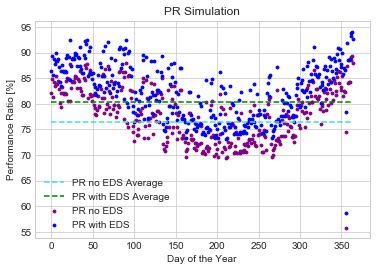

In [12]:
#Plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#pr no eds
x1 = range(365)
y1 = pr_no_eds
#pr with eds
x2 = range(365)
y2 = pr_eds
#pr no eds average
x3 = range(365)
y3 = [0.7642478084807013*100*x for x in np.ones(365)]
#pr eds average
x4 = range(365)
y4 = [0.8044472432067862*100*x for x in np.ones(365)]

plt.scatter(x1, y1,s=8, c='purple', marker="o", label='PR no EDS')
plt.scatter(x2, y2,s=8, c='blue', marker="o", label='PR with EDS')
plt.plot(x3,y3,'--',c='turquoise',label='PR no EDS Average')
plt.plot(x4,y4,'--',c="green",label='PR with EDS Average')
plt.ylabel('Performance Ratio [%]')
plt.xlabel('Day of the Year')
plt.title('PR Simulation')
plt.legend(loc='lower left')
plt.savefig("pr_plot")

In [58]:
#Soiling Ratio and Soiling Rate Measurement
#No EDS
model = create_sam_lcoe(model_inputs)
outputs = model.Outputs.export()
dc_hourly = outputs['dc']

# get daily dc power data in w
day_counter = 1
dc_counter = 0
dc_daily = []

for x in range(8760):
    if (day_counter%24==0):
        day_counter = 1
        dc_daily.append(dc_counter)
        dc_counter = 0
    else:
        dc_counter = dc_counter + dc_hourly[x]
        day_counter = day_counter + 1

# set time period of 4 weeks
dc_daily = dc_daily[0:31]

#define the isc clean
isc_clean = dc_daily

#No eds condition, isc dirty
isc_no_eds = []
counter = 0
for x in range(31):
    if (x==0):
        isc_no_eds.append(isc_clean[x])
        counter = counter + 1
    elif (x == 14):
        isc_no_eds.append(isc_clean[x]*0.98)
        counter = 0
    elif (x == 29):
        isc_no_eds.append(isc_clean[x]*0.98)
        counter = 0
    else:
        isc_no_eds.append(isc_clean[x]*(0.98)**(counter+1))
        counter = counter + 1

#Eds activated simulation
isc_eds = []
for x in range(31):
    if (x == 0):
        res = isc_clean[x]
        isc_eds.append(res)
    else:
        res = isc_clean[x]*(0.9987)**(x)
        isc_eds.append(res)

#this is the isc clean
#isc dirty will be multiplied by 99%
#eds will give gain 1.05% from isc dirty

#SR no eds
SR_no_eds = []
for x in range(31):
    SR_no_eds.append(isc_no_eds[x]/isc_clean[x])

#SR with eds
SR_eds = []
for x in range(31):
    SR_eds.append(isc_eds[x]/isc_clean[x])

In [59]:
#SR avg no eds
sr_no_eds_avg = sum(SR_no_eds)/len(SR_no_eds)
sr_no_eds_avg

0.8742932172728904

In [60]:
#SR avg  eds
sr_eds_avg = sum(SR_eds)/len(SR_eds)
sr_eds_avg

0.9807428356115069

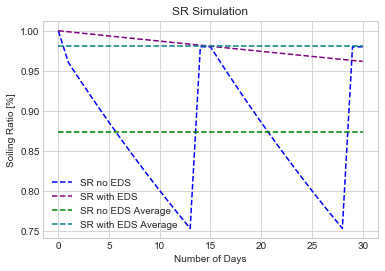

In [62]:
#Plotting Soiling Ratio Simulation
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#SR no eds
x1 = range(31)
y1 = SR_no_eds
#SR with eds
x2 = range(31)
y2 = SR_eds
#SR no eds average
x3 = range(31)
y3 = [0.8742932172728904*x for x in np.ones(31)]
#SR eds average
x4 = range(31)
y4 = [0.9807428356115069*x for x in np.ones(31)]

plt.plot(x1,y1,'--',c='blue',label='SR no EDS')
plt.plot(x2,y2,'--',c='purple',label='SR with EDS')
plt.plot(x3,y3,'--',c='green',label='SR no EDS Average')
plt.plot(x4,y4,'--',c="teal",label='SR with EDS Average')
plt.ylabel('Soiling Ratio [%]')
plt.xlabel('Number of Days')
plt.title('SR Simulation')
plt.legend(loc='lower left')
plt.savefig("SR_plot")

In [63]:
from scipy import stats
import matplotlib.pyplot as plt

In [64]:
x = range(31)
y = SR_no_eds
res = stats.theilslopes(y, x)
soiling_rate_no_eds = res[0]
soiling_rate_no_eds

-0.00462481338604209

In [65]:
x = range(31)
y = SR_eds
res = stats.theilslopes(y, x)
soiling_rate_eds = res[0]
soiling_rate_eds

-0.0012757318078481447

In [68]:
#Financial Viability Analysis
solar_elec_eff = 0.18
LCOE = 0.06 #$/kWh
energy = outputs['solrad_annual'] #kwh/year/m2
lifetime = 25 #years

In [67]:
energy

5.828503801109412

In [71]:
#SR ANALYSIS
cost_savings_no_eds = soiling_rate_no_eds * solar_elec_eff * energy * 365 * lifetime * LCOE
cost_savings_no_eds

-2.656488413516848

In [72]:
cost_savings_eds = soiling_rate_eds * solar_elec_eff * energy * 365 * lifetime * LCOE
cost_savings_eds

-0.7327791379716126

In [19]:
#PR ANALYSIS
cost_savings_no_eds = 0.7642478084807013 * solar_elec_eff * energy * 365 * lifetime * LCOE
cost_savings_no_eds

438.9832148496875

In [20]:
#PR ANALYSIS
cost_savings_no_eds = 0.8044472432067862 * solar_elec_eff * energy * 365 * lifetime * LCOE
cost_savings_no_eds


462.0737319507811

NameError: name 'empty' is not defined